In [1]:
import astropy
from astropy.table import Table
from astropy.io import ascii
from astropy.io import fits

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import ttest_ind

File = "data/m-sig_table_con_tc.csv"
data = ascii.read(File)

with fits.open("Data/AGN_V1.fits") as data2:
    data2.info()
    data_AGN_BH = data2[0].data[2]
    data_AGN_SI = data2[0].data[3]

data_by_type = data.group_by("Type")

early_type = data_by_type.groups[0:9]
late_type = data_by_type.groups[9:18]

print("The data has been successfully loaded.")

Filename: Data/AGN_V1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (87860, 4)   float64   
The data has been successfully loaded.


# Distributions in the data

In this section we take a look at some potential distributions in the data of Gültekin et al.(2009). The first of these, as seen in Figure """""", is the $M-\sigma$ relation. The data set has been split into Early-type (E and S0) and Late-type (S) galaxies. As can be seen in the plot, in log-log space there appears to be a linear correlation between the mass $M$ of the central Supermassive Black Hole and the velocity dispersion $\sigma$ of the surrounding stars.

In Figure """""", we looked at the relation between the Bulge Luminosity and the velocity dispersion. Only three Late-type galaxies in this data set had Bulge Luminosity data, but there are enough Early-type galaxies to see a linear relation in log-log similar to the $M-\sigma$ relation seen before.

We also looked at the Total Luminosity versus $\sigma$ relation, as seen in Figure """"""". Here the correlation appears much weaker, with a larger spread of the data.

We also investigated the distribution of the Black Hole masses, seen in the histogram in figure """""". Most Black Holes in this sample have masses below $0.5 * 10^9 M_{sun}$, and all late-type galaxies have Black Hole masses below $10^9 M_{sun}$. 

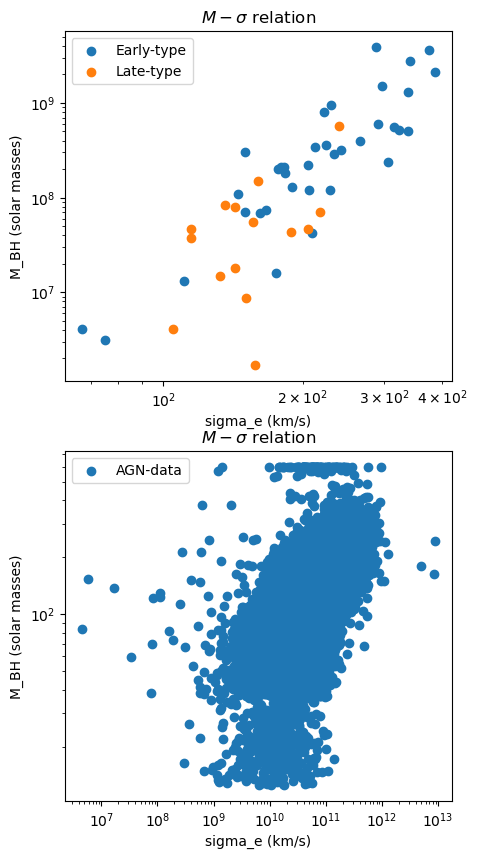

In [3]:
fig, axs = plt.subplots(2, 1, figsize=(5, 10))

x = "sigma_e (km/s)"
y = "M_BH (solar masses)"

axs[0].scatter(early_type[x], early_type[y], label="Early-type")
axs[0].scatter(late_type[x], late_type[y], label="Late-type")

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_title(r"$M-\sigma$ relation")
axs[0].legend()
axs[0].set_xlabel(x)
axs[0].set_ylabel(y)

x = "sigma_e (km/s)"
y = "M_BH (solar masses)"

axs[1].scatter(data_AGN_BH, data_AGN_SI, label="AGN-data")

axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_title(r"$M-\sigma$ relation")
axs[1].legend()
axs[1].set_xlabel(x)
axs[1].set_ylabel(y)

plt.show()

Figure """""": The $M-\sigma$ relation, a linear in log-log-space relation between the masses of the central Supermassive Black Holes in solar masses and the velocity dispersion $\sigma$ of the bulge stars. This relation holds for both early- and late-type galaxies.

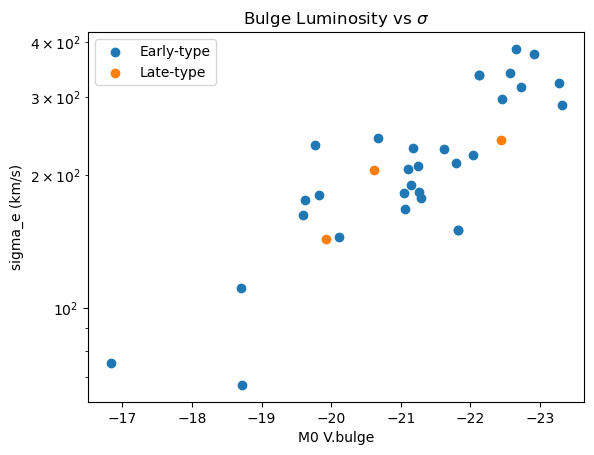

In [5]:
y = "sigma_e (km/s)"
x = "M0 V.bulge"


plt.scatter(early_type[x], early_type[y], label="Early-type")
plt.scatter(late_type[x], late_type[y], label="Late-type")
    
plt.yscale('log')
plt.gca().invert_xaxis()
plt.title(r"Bulge Luminosity vs $\sigma$")
plt.legend()
plt.xlabel(x)
plt.ylabel(y)

plt.show()

Figure """"""": Interestingly, there also seems to be a log-log-linear relation between Bulge luminosity in magnitudes and velocity dispersion $\sigma$ , though we only have enough data for early-type galaxies. 3 data points for late types is not enough to make statistical statements with any certainty.

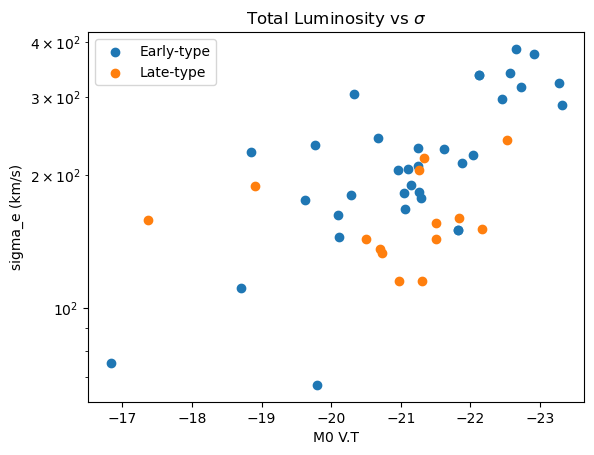

In [7]:
y = "sigma_e (km/s)"
x = "M0 V.T"

plt.scatter(early_type[x], early_type[y], label="Early-type")
plt.scatter(late_type[x], late_type[y], label="Late-type")
    
plt.yscale('log')
plt.gca().invert_xaxis()
plt.title(r"Total Luminosity vs $\sigma$")
plt.legend()
plt.xlabel(x)
plt.ylabel(y)

plt.show()

Figure """"""": The total luminosity of the host galaxy against velocity dispersion $\sigma$ doesnt show as much correlation however. The spread is way more pronounced than in the previous plots.

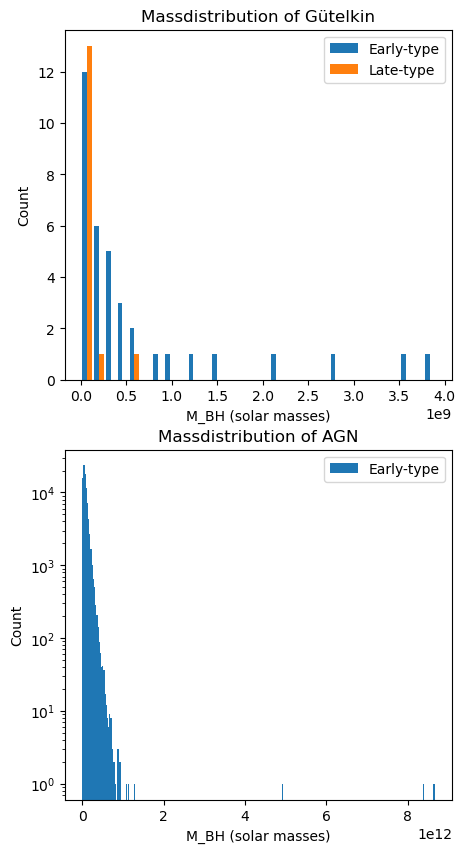

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(5, 10))

x = "M_BH (solar masses)"

axs[0].hist((early_type[x], late_type[x]), label = ("Early-type", "Late-type"), bins = 30)

axs[0].legend()
axs[0].set_title("Massdistribution of Gütelkin")
axs[0].set_xlabel(x)
axs[0].set_ylabel("Count")


axs[1].hist(data_AGN_BH, label = ("Early-type", "Late-type"), bins = 300)

axs[1].legend()
axs[1].set_title("Massdistribution of AGN")
axs[1].set_xlabel(x)
axs[1].set_ylabel("Count")

axs[1].set_yscale('log')

plt.show()

Figure """""": A histogram of Black Hole masses, as can be seen, early-type galaxies have a very spread out distribution of BH masses, with a trailing off tail towards higher masses.

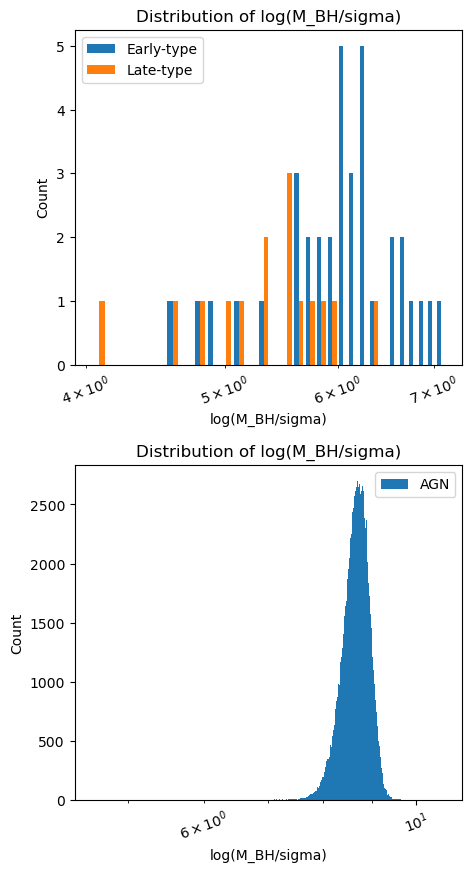

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(5, 10))
plt.subplots_adjust(hspace=0.3)

x = "M_BH (solar masses)"
y = "sigma_e (km/s)"

axs[0].hist((np.log10(early_type[x]/early_type[y]), np.log10(late_type[x]/late_type[y])), label=("Early-type", "Late-type"), bins=30)
axs[0].set_xscale("log")

axs[0].legend()
axs[0].set_title("Distribution of log(M_BH/sigma)")
axs[0].tick_params(axis="x", which="both", labelrotation=20)
axs[0].set_xlabel("log(M_BH/sigma)")
axs[0].set_ylabel("Count")

axs[1].hist(np.log10(data_AGN_BH/data_AGN_SI), label="AGN", bins=300)
axs[1].set_xscale("log")

axs[1].legend()
axs[1].set_title("Distribution of log(M_BH/sigma)")
axs[1].tick_params(axis="x", which="both", labelrotation=20)
axs[1].set_xlabel("log(M_BH/sigma)")
axs[1].set_ylabel("Count")

plt.show()

Figure """""": Taking a look at the distribution of Black Hole masses divided by $\sigma$, surprisingly the early-types almost look to be lognormal distributed. We havent yet checked wether they actually are in a lognormal distribution, nor do we know if this is physically relevant, but this definetly warrants a closer look.

The next code block defines the final data, which were used for the further research. This is used, because it is easier to handle a dictionary in a for loop, which were used to plot many plots, with different data at once.

In [14]:
x = "sigma_e (km/s)"
y = "M_BH (solar masses)"

DATA_SET= { "Early": [np.log10(early_type[x]), np.log10(early_type[y])],
            "Late"  : [np.log10(late_type[x]), np.log10(late_type[y])],
            "AGN"   : [np.log10(data_AGN_SI), np.log10(data_AGN_BH)],
            "Gütel" : [np.log10(data["sigma_e (km/s)"]), np.log10(data["M_BH (solar masses)"])]}

DATA_SET_N = {"Early": [early_type[x], early_type[y]],
              "Late"  : [late_type[x], late_type[y]],
              "AGN"   : [data_AGN_SI, data_AGN_BH],
              "Gütel" : [data["sigma_e (km/s)"], data["M_BH (solar masses)"]]}

DIST_GUETEL = np.array(data["Dist (million parsecs)"])

early_type = None
late_type = None
data = None

# Statistics of the data




Fit result36.926570185264026


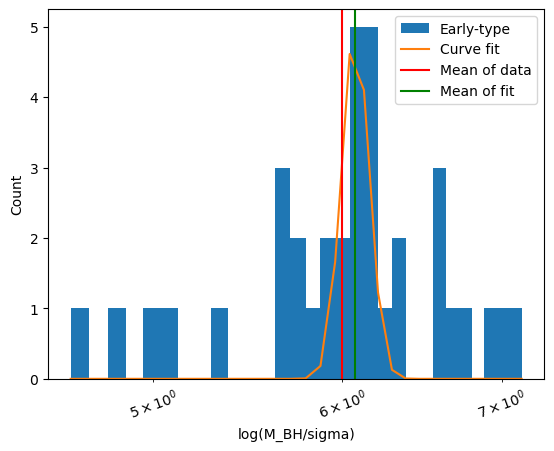

In [16]:
def logfunc(x, mu, sigma):
    return (1/((x)*np.sqrt(2*np.pi*(sigma**2))))*np.exp((-(np.log(x)-mu)**2)/(2*(sigma**2)))

bins = 30
plt.hist((np.log10(DATA_SET_N["Early"][1]/DATA_SET_N["Early"][0])), label = "Early-type", bins = bins)
y_data, x_data = np.histogram(np.log10(DATA_SET_N["Early"][1]/DATA_SET_N["Early"][0]), bins = bins) 

popt, pcov = curve_fit(logfunc, x_data[:-1], y_data)

plt.xscale("log")

plt.plot((x_data), (logfunc(x_data, popt[0], popt[1])), label = "Curve fit")
plt.axvline((np.average(a = x_data[:-1], weights = y_data)), color = "r", label = "Mean of data")
plt.axvline(np.exp(popt[0]), color = "g", label = "Mean of fit")

#print(np.exp(2*popt[0]+(popt[1]**2))*(np.exp(popt[1])-1))
#print(np.exp(popt[1])**2)
print(f"Fit result{np.exp(2*popt[0]+2*(popt[1]**2))}")

plt.legend()
plt.tick_params(axis = "x", which = "both", labelrotation = 20)
plt.xlabel("log(M_BH/sigma)")
plt.ylabel("Count")


plt.show()


Because fitting a lognormal function to the above distribution did not work, it seems likely that the data is not lognormal distributed, but merely appeared that way due to the chosen bin size of the histogram.

Mean of Data: 0.000
Variance of Data (not ^2): 0.000
2-sigma confidence interval for mean: (0.000, 0.000)
5-sigma confidence interval for mean: (-0.000, 0.000)


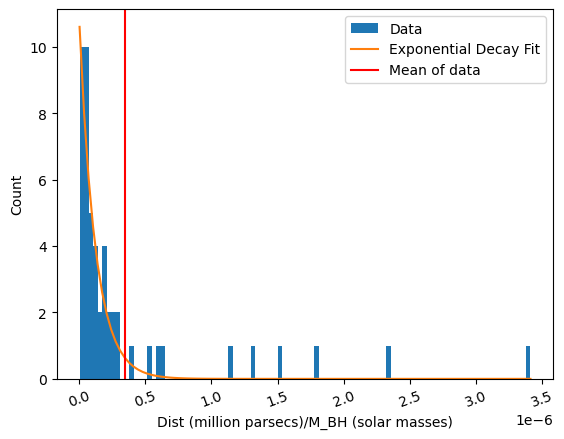

In [18]:
def Mean(X):
    return np.sum(X)/len(X)

def Sig(X):
    return (np.sum((X-Mean(X))**2)/(len(X)-1))**0.5

def exp_decay(x, N_0, lam):
    return N_0*np.exp(-lam*x)


bins = 100

ploted_Data = DIST_GUETEL / DATA_SET_N["Gütel"][1]

plt.hist((ploted_Data), label = "Data", bins = bins)
y_data, x_data = np.histogram((ploted_Data), bins = bins)

popt, pcov = curve_fit(exp_decay, x_data[:-1], y_data)
plt.plot(x_data, exp_decay(x_data, popt[0], popt[1]), label = "Exponential Decay Fit")
#print(popt)

mean = Mean(ploted_Data)
var = Sig(ploted_Data)

print(f"Mean of Data: {mean:.3f}")
print(f"Variance of Data (not ^2): {var:.3f}")

plt.axvline(mean, color = "r", label = "Mean of data")

two_sig_conf = (mean-2*(var/np.sqrt(len(ploted_Data))), mean+2*(var/np.sqrt(len(ploted_Data))))
five_sig_conf = (mean-5*(var/np.sqrt(len(ploted_Data))), mean+5*(var/np.sqrt(len(ploted_Data))))

print(f"2-sigma confidence interval for mean: ({two_sig_conf[0]:.3f}, {two_sig_conf[1]:.3f})")
print(f"5-sigma confidence interval for mean: ({five_sig_conf[0]:.3f}, {five_sig_conf[1]:.3f})")

plt.legend()
plt.tick_params(axis="x", which="both", labelrotation=20)
plt.xlabel("Dist (million parsecs)/M_BH (solar masses)")
plt.ylabel("Count")
plt.show()

Distance over Black Hole mass almost certainly doesnt follow a physically relevant distribution, unless you look at Black Holes billions of parsecs away, as you would be looking into the early universe. It does however follow a instrument related distribution. To get good data of Black Holes far away, you need to look at bigger, and therefor more massive Black Holes. Distance/Black Hole mass should therefor be almost constant, and as can be seen in the distribution above, most values lie very close together, with only a few outliers to the left at higher distances compared to Black Hole mass. Additionally, as seen in the plots below, most of the data points for both distance and Blck Hole mass have similar values in the first place, so their combined quantitiy following the above distribution is expected.

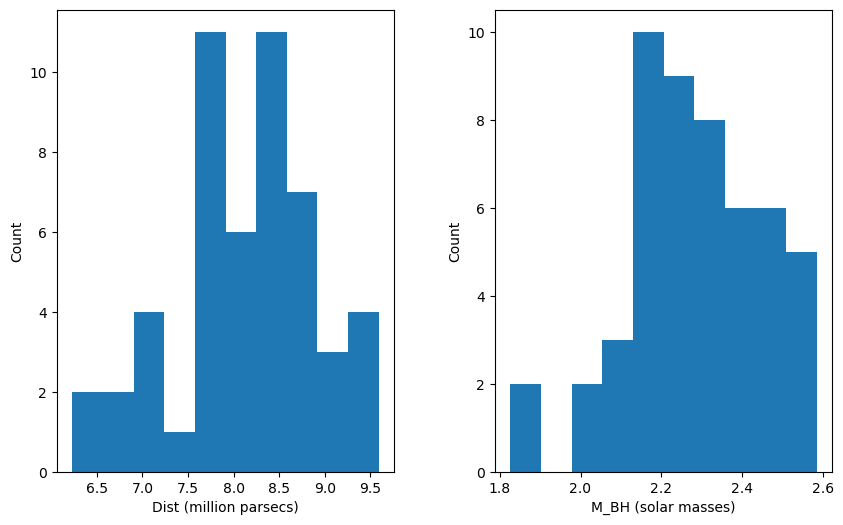

In [20]:
fig, axs = plt.subplots(1, 2, figsize=[10, 6]) 
plt.subplots_adjust(wspace=0.3)

axs[0].hist(DATA_SET["Gütel"][1])
axs[0].set_xlabel("Dist (million parsecs)")
axs[0].set_ylabel("Count")

axs[1].hist(DATA_SET["Gütel"][0])
axs[1].set_xlabel("M_BH (solar masses)")
axs[1].set_ylabel("Count")

plt.show()

# Hypothesis testing
We have two Black Hole mass samples, one from our paper ($\mu_1$) and one from the AGN catalog ($\mu_2$). We test wether these samples have the same mean BH mass. \
$H_0$: $\mu_1 = \mu_2$ \
$H_a$: $\mu_1 \neq \mu_2$


Mean Gütelkin: 8.120e+00
Mean AGN: 1.078e+01
Standard deviation Gütelkin: 2.098e+00
Standard deviation AGN: 6.254e+00
t-value: -9.030
95% Confidence Interval: (-3.237e+00, -2.082e+00)
12.9376


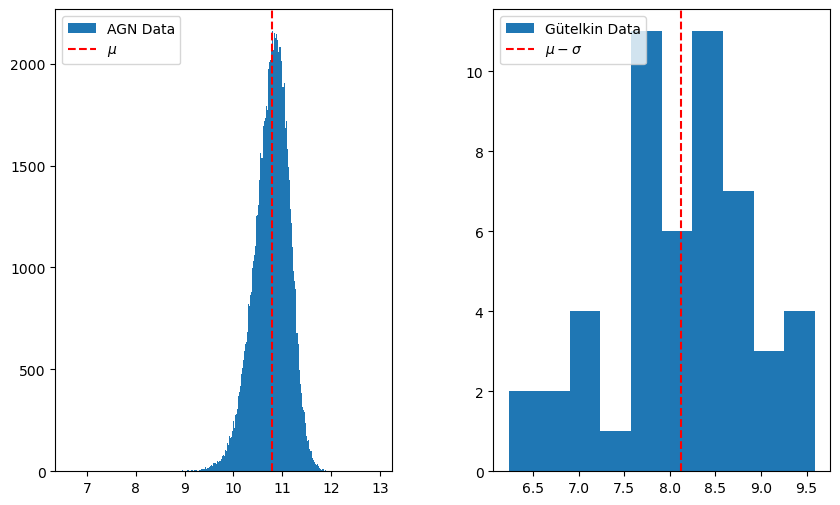

TtestResult(statistic=-23.952454245774753, pvalue=4.6017070135728964e-29, df=50.0121859061996)

In [22]:
# Means for both data sets
mean_Guetel = Mean(DATA_SET["Gütel"][1])
mean_AGN =  Mean(DATA_SET["AGN"][1])

# Standard deviation for both data sets
std_Guetel = np.sum((DATA_SET["Gütel"][1]-mean_Guetel)**2)/((len(DATA_SET["Gütel"][1]))**0.5)
std_AGN = np.sum((DATA_SET["AGN"][1]-mean_AGN)**2)/((len(DATA_SET["AGN"][1]))**0.5)

std_Guetel = std_Guetel**(1/2)
std_AGN = std_AGN**(1/2)

print(f"Mean Gütelkin: {mean_Guetel:.3e}")
print(f"Mean AGN: {mean_AGN:.3e}")

print(f"Standard deviation Gütelkin: {std_Guetel:.3e}")
print(f"Standard deviation AGN: {std_AGN:.3e}")

# The t-value, for "case 2" in the lecture notes, large sample sizes with population standard deviations
T = (mean_Guetel - mean_AGN)/(np.sqrt(std_Guetel**2/len(DATA_SET["Gütel"][1])+std_AGN**2/len(DATA_SET["AGN"][1])))
print(f"t-value: {T:.3f}")

# 95% Confidence interval, has to contain 0 for means to not be different

lower = (mean_Guetel - mean_AGN)-1.96*np.sqrt(((std_Guetel**2)/len(DATA_SET["Gütel"][1]))+((std_AGN**2)/len(DATA_SET["AGN"][1])))
upper = (mean_Guetel - mean_AGN) + 1.96*np.sqrt((std_Guetel**2/len(DATA_SET["Gütel"][1]))+(std_AGN**2/len(DATA_SET["AGN"][1])))

print(f"95% Confidence Interval: ({lower:.3e}, {upper:.3e})")
print(max(DATA_SET["AGN"][1]))

fig, axs = plt.subplots(1, 2, figsize=[10, 6]) 
plt.subplots_adjust(wspace=0.3)

axs[0].hist(DATA_SET["AGN"][1], bins = 300, label="AGN Data")
axs[0].axvline(mean_AGN, color = "r", label = r"$\mu$", linestyle="--")
axs[0].legend()

axs[1].hist(DATA_SET["Gütel"][1], label="Gütelkin Data")
axs[1].axvline(mean_Guetel, color = "r", label = r"$\mu-\sigma$", linestyle="--")
axs[1].legend()

plt.show()

ttest_ind(DATA_SET["Gütel"][1], DATA_SET["AGN"][1], equal_var = False)

As it turns out, the two means of these samples are so far apart, our p-value is zero, and our 95% confidence interval is 11 orders of magnitude away from zero.

# Linear Regression



Firstly the correlation coefficient $r=\rho$ were calculated, to know if a correlation can be assumed or not:
$$ r = \frac{\sum{}(x_i-\overline{x})(y_i-\overline{y})}{\sqrt{sum{}(x_i-\overline{x})^2(y_i-\overline{y})^2}}$$

r can be between -1 and 1. If the R=0, than no relation can be assumed. The greater the absolute value is, the greater the correlation. -1 is for a negativ slope and +1 for a positv slope.

With the r a t-test can be calculated (for a data set of n data points): 
$$ t= \frac{r\sqrt{n-2}}{\sqrt{1-r^2}} $$

To get the p-value, it is "necessary" to look at at table or calculate it with a computer. 

The calculations were done with scipy.stats.pearsonr

In [25]:
from scipy.stats import pearsonr

r = {}
p_value = {}

#enumerate takes one interaiable Object (eg. list) and 
#returns 2 parameters: 1. index, 2. value

for i, v in enumerate(DATA_SET):
    rr, p = pearsonr(DATA_SET[v][0], DATA_SET[v][1])
    r[v] = rr
    p_value[v] = p

    temp = "rejected"
    if p_value[v] <= 0.05:
        temp = "not rejected"
    print(f"{v}: {temp}")
    print(f"r={r[v]:.3f}")
    print(f"p={p_value[v]*100:.3f}%\n")


Early: not rejected
r=0.880
p=0.000%

Late: rejected
r=0.480
p=7.010%

AGN: not rejected
r=0.673
p=0.000%

Gütel: not rejected
r=0.836
p=0.000%



With a signifcant level of 95%, only the late types can be rejected. But for the AGN the r value is very small, thefore the probabilty, if there is a realtionship is very low. 

In the next section the linear regression is done. For that statsmodels.api were used. This libary do the linear regression, and also calulates values. For the Linear Regression the following equation were used:
$$ \log \left( \frac{M}{M_\odot} \right) = \alpha + \beta \log \left( \frac{\sigma}{200} \right) $$

This equation were taken, to compare our results with the litature. For right use of the varaible, it is necessary to remove $\log 200$ from $$\log sig$$.  

The value bse of the libaray is the standard Error and can be calculated as followed: 
$$ SE(\hat{\beta_i}) = \sqrt{\hat{\sigma^2}(X^TX)_{ii}^{-1}} $$

$\beta_i$ are the coeffeicents, X is a matrix and $\sigma^2$ is the resedium error. 

In [27]:
import statsmodels.api as sm

fitData_WTF = [DATA_SET[v][0]-np.log(200)/np.log(10) for v in DATA_SET]
results = []

RESULT = []

for i, v in enumerate(DATA_SET):
    fitData_WTF[i] = sm.add_constant(fitData_WTF[i])
    model = sm.OLS(DATA_SET[v][1], fitData_WTF[i])
    results.append(model.fit())
    
    #print(results[-1].summary())
    #print("\n+++++++++++++++n")

    RESULT.append((results[-1].params[1], results[-1].params[0]))
    #print(v, ": ", RESULT[-1])
    print(f"{v}:\n Parameters of straight: log(Mbh) = {results[-1].params[1]:.3f} + {results[-1].params[0]:.3f} * log(sigma/200)")
    #print("\n*******************\n")
    

Early:
 Parameters of straight: log(Mbh) = 3.682 + 8.269 * log(sigma/200)
Late:
 Parameters of straight: log(Mbh) = 2.881 + 7.871 * log(sigma/200)
AGN:
 Parameters of straight: log(Mbh) = 1.502 + 11.042 * log(sigma/200)
Gütel:
 Parameters of straight: log(Mbh) = 3.912 + 8.183 * log(sigma/200)


In [ ]:
####################### Functions ######################
def Covariance(X, Y):
    Mx = Mean(X)
    My = Mean(Y)
    return np.sum((X-Mx)*(Y-My))/(len(X)-1)

def Pearson(cov, sigX, sigY):
    return cov/(sigX*sigY)

#bootstrap
def Slope(X, Y):
    X_mean = Mean(X)
    Y_mean = Mean(Y)
    return np.sum((X - X_mean) * (Y - Y_mean))/np.sum((X - X_mean) ** 2)

def Bootstrap(X, Y, alpha=1-0.683, k=100, ):
    """
    Do the Bootstrap alogrithm

    Parameter:
    X (list of float): X-Values 
    Y (list of float): Y-Values
    alpha: how many data are included (normal = one sigma)
    
    Returnvalues:
    int oder float: Die Summe von a und b.
    float: the intercept of the fit
    float: the mean value of the slope
    flaot: the variance of the slope
    (float, float): the confidence interval of the slope
    (float, float): the minimum slope (index 0) and the maximum slope (index 1) 
    [floats, ...]: all the calculated slopes (k-time)
    """
    slope = []
    # bootstrap
    for j in range(k):
        ii = np.random.choice(len(DATA_SET[v][0]), size=len(DATA_SET[v][0]), replace=True)
        x_temp = DATA_SET[v][0][ii]
        y_temp = DATA_SET[v][1][ii]

        slope.append(Slope(x_temp, y_temp))

    
    slopeSorted = np.sort(slope)
    meanSlope = Mean(slope)
    varSlope = Sig(slope)
    confSlope = (meanSlope-varSlope, meanSlope+varSlope)
    
    minSlope = slopeSorted[int((alpha/2) * k)]
    maxSlope = slopeSorted[int((1 - alpha/2) * k)]
    extremsSlope = (minSlope, maxSlope)

    offset = Mean(Y) - meanSlope * Mean(X) + np.log10(200)*meanSlope
    
    return offset, meanSlope, varSlope, confSlope, extremsSlope, slope

fit  = lambda k, d, x: k*x+d-k*np.log10(200)

####################### End Functions ######################

####################### Variables ######################
#Slope parameters
slopy = {} #every slope 
minSlopy = {} #minimum slope
maxSlopy = {} #maxsimum slope
meanSlopy = {} #mean slope (which were used for the fit)
s1ConfI = {} #1 sigma confidence Interval of the slopes

#oher parameters
offsets = {} #offsets of the function
residiun = {} #errors of the fit
varRe = {} #variance of the errors
SE = {} #Standard Error 
cov = {}
per = {}

x_values = np.logspace(-1, 1, 100)

# Bootstrap parameters
k = 100
alpha = 1-0.683
####################### End Variables ######################

####################### Plot Configuration ######################
fig, axs = plt.subplots(4, 2, figsize=[10, 16]) #width height in inches
plt.subplots_adjust(hspace=0.5, wspace=1.2)

#a dictionary with the limtis of the x and y axis for the subplots
limits = {"Early": {"x": (1.7, 2.7), "y": (4,12)},
          "Late" : {"x": (1.7, 2.7), "y": (4,12)},
          "AGN"  : {"x": (1, 3),   "y": (6,15)},
          "Gütel": {"x": (1.7, 2.7), "y": (4,12)}}
####################### End Plot Confiuration ######################

####################### Create Subplot ######################
for i, v in enumerate(DATA_SET):
    # Bootstrap, error of it, ...
    offsets[v], meanSlopy[v], _, s1ConfI[v], temp, slopy[v]  = Bootstrap(DATA_SET[v][0], DATA_SET[v][1], alpha, k)
    minSlopy[v] = temp[0]
    maxSlopy[v] = temp[1]

    y_lower = fit(minSlopy[v], offsets[v], x_values)
    y_upper = fit(maxSlopy[v], offsets[v], x_values)
    y_temp = fit(meanSlopy[v], offsets[v], x_values)

    y_1sigL = fit(s1ConfI[v][0], offsets[v], x_values) 
    y_1sigU = fit(s1ConfI[v][1], offsets[v], x_values) 

    residiun[v] = DATA_SET[v][1] - meanSlopy[v]*DATA_SET[v][0]+offsets[v]
    varRe[v] = 1/(len(residiun[v])-2)*np.sum(residiun[v]) # Internet (=s^2)

    b = (varRe[v]/np.sum((DATA_SET[v][1]-Mean(DATA_SET[v][1]))**2))**0.5 # Internet
    a = (varRe[v]*(1/len(DATA_SET[v][1]) + Mean(DATA_SET[v][1])/np.sum((DATA_SET[v][1]-Mean(DATA_SET[v][1])**2))))**0.5 # Inernet            
    SE[v] = {"a": a, "b": b}
    #Source: https://people.duke.edu/~rnau/mathreg.htm

    
    #setup 1. plot, data + fit
    funcText = rf"$\log M_{{BH}}={RESULT[i][1]:.1f}+{RESULT[i][0]:.1f}\log{{(\sigma/200)}}$"
    funcText2 = rf"$\log M_{{BH}}={offsets[v]:.1f}+{meanSlopy[v]:.1f}\log{{(\sigma/200)}}$"

    axs[i][0].scatter(DATA_SET[v][0], DATA_SET[v][1], label="Data", s=10) #meassurement Data
    axs[i][0].plot(x_values, fit(RESULT[i][0], RESULT[i][1], x_values), label=funcText, color="orange") #Fit from the statsmodel

    axs[i][0].plot(x_values, y_temp, color='black', label=funcText2) #Fit from bootstrap
    axs[i][0].plot(x_values, y_lower, color="pink", alpha=0.8, label=fr"min and max slope")
    axs[i][0].plot(x_values, y_upper, color="pink", alpha=0.8, label=fr"min and max slope")
    #axs[i][0].fill_between(x_values, y_lower, y_upper, color="pink", alpha=0.5, label=fr"min and max slope") #Minimum and maximum slopes
    axs[i][0].fill_between(x_values, y_1sigL, y_1sigU, color="Green", alpha=0.2, label=fr"1$\sigma$")


    #setup 2. plot, bootstrap di 
    axs[i][1].hist(slopy[v], bins = 50, label="")
    axs[i][1].axvline(minSlopy[v], color="red", label=rf"$\mu-\sigma = {minSlopy[v]:.3f}$ ")
    axs[i][1].axvline(maxSlopy[v], color="red", label=rf"$\mu+\sigma = {maxSlopy[v]:.3f}$")
    axs[i][1].axvline(meanSlopy[v], color="green", label=rf"$\mu$ = {meanSlopy[v]:.3f}")
    
    #Calulations
    cov[v] = Covariance(DATA_SET[v][1], fit(RESULT[i][0], RESULT[i][1], DATA_SET[v][0]))
    per[v] = Pearson(cov[v], Sig(DATA_SET[v][1]), Sig(fit(RESULT[i][0], RESULT[i][1], DATA_SET[v][0])))

    #Subpllotinfos
    axs[i][0].set_title(v)

    axs[i][0].set_xlim(limits[v]["x"][0], limits[v]["x"][1])
    axs[i][0].set_ylim(limits[v]["y"][0], limits[v]["y"][1])

    axs[i][0].set_xlabel(r"$log(\sigma) [km s^{-1}]$")
    axs[i][0].set_ylabel(r"$log(M_{BH}) [M_*)$")
    axs[i][0].legend(loc='upper left', bbox_to_anchor=(1, 1.05))

    axs[i][1].legend(loc='upper left', bbox_to_anchor=(1, 1.05))
    axs[i][1].set_title("Bootstrap distribution "+v)

####################### End Create Subplot ######################

plt.show()

####################### Display the parameters ######################
for i, v in enumerate(DATA_SET):
    print(v)
    print(" Parameters from statsmodel")
    print(f"  Standard error: {results[i].bse[1]:.3f}, {results[i].bse[0]:.3f},")
    print(f"  Covariance = {cov[v]:.3f}")
    print(f"  Pearson = {per[v]:.3f}")
    print(f"  Pearson(library)= {r[v]:.3f}")
    print(" Parameters from Bootstrap")
    print(f"  Bootstrap: min: {minSlopy[v]:.3f}, max: {maxSlopy[v]:.3f}, normal: {meanSlopy[v]:.3f}")
    print(f"  Confidence Interval (1 sigma) for the slope: ({s1ConfI[v][0]:.3f}, {s1ConfI[v][1]:.3f})")
    print(f"  Slope = {meanSlopy[v]:.3f}, Offset = {offsets[v]:.3f}")
    print(f"  Residuum: min: {min(residiun[v]):.3f}, max: {max(residiun[v]):.3f}, mean: {np.sum(residiun[v])/len(residiun[v]):.3f}")
    print(f"  Standard error (new): {SE[v]["a"]:.3f}, {SE[v]["b"]:.3f}")
    print(f"  Mean Residuum = {Mean(residiun[v]):.3f}")
    
    print("================================")

####################### End Display the parameters ######################